In [359]:
from loading_data import queryDB
import pandas as pd

In [360]:
import json
import numpy as np
import copy
import os

config_path = 'config.json'

with open(config_path) as config_buffer:
   config = json.loads(config_buffer.read())

model_path = config['model_weights']
num_concepts = len(config['conceptids'])
class_map_file = config['class_map']
concepts = config['conceptids']
classmap = pd.read_csv(class_map_file, header=None).to_dict()[0]

In [809]:
counts = queryDB('''
    select videoid, count(*) as total, 
        sum(case when conceptid=1629 then 1 else 0 end) As count1629, 
        sum(case when conceptid=1210 then 1 else 0 end) As count1210, 
        sum(case when conceptid=236 then 1 else 0 end) As count236, 
        sum(case when conceptid=383 then 1 else 0 end) As count383, 
        sum(case when conceptid=1133 then 1 else 0 end) As count1133 
    from annotations where userid != 17 and conceptid in (1629, 1210, 236, 383, 1133)
    group by videoid 
    order by total desc;
       ''')

counts.head(20)
       

,videoid,total,count1629,count1210,count236,count383,count1133
0,37,3916,0,4,2885,1024,3
1,39,2186,0,0,1077,1108,1
2,38,1032,0,0,660,371,1
3,34,941,0,2,860,78,1
4,24,459,0,0,459,0,0
5,32,420,0,61,80,273,6
6,33,340,0,16,208,109,7
7,86,331,0,40,143,148,0
8,98,309,0,29,181,97,2
9,35,288,0,9,221,58,0


In [3]:
queryDB("select * from videos where filename='DocRicketts-0701_20141216T212020Z_00-48-12-26TC_h264.mp4'")


,id,filename,gpsstart,gpsstop,starttime,endtime,startdepth,enddepth,description
0,8,DocRicketts-0701_20141216T212020Z_00-48-12-26T...,"(36.798367,-122.108671)","(36.798215,-122.108195)",2014-12-16 21:20:20,2014-12-16 21:36:20,217,149,


In [868]:
annotations = queryDB('select * from annotations where videoid=86 and userid!=17')


In [941]:
annotations.describe()

,id,videoid,userid,conceptid,timeinvideo,x1,y1,x2,y2,videowidth,videoheight,originalid,frame_num
count,4.260000e+02,426.0,426.0,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.0,426.0,4.260000e+02,426.000000
mean,4.992865e+06,86.0,15.0,791.615023,577.884929,589.577461,297.201883,807.100936,449.443666,1600.0,900.0,4.992865e+06,17319.239437
std,1.179730e+04,0.0,0.0,920.209811,251.202025,458.038157,181.217903,458.311577,182.357451,0.0,0.0,1.179730e+04,7528.536257
min,4.972101e+06,86.0,15.0,236.000000,5.742937,0.000000,0.000000,65.000000,92.000000,1600.0,900.0,4.972101e+06,172.000000
25%,4.982566e+06,86.0,15.0,236.000000,391.105275,151.000000,160.250000,404.250000,317.000000,1600.0,900.0,4.982566e+06,11721.500000
50%,4.993876e+06,86.0,15.0,383.000000,633.709255,526.000000,279.000000,754.499992,437.999992,1600.0,900.0,4.993876e+06,18992.500000
75%,5.002300e+06,86.0,15.0,1034.000000,763.136184,967.999996,414.500031,1168.749996,572.499989,1600.0,900.0,5.002300e+06,22871.000000
max,5.012794e+06,86.0,15.0,3386.000000,959.292507,1537.999985,791.000031,1599.000000,899.000000,1600.0,900.0,5.012794e+06,28750.000000


In [870]:
# Get the IOU value for two different annotations
def compute_overlap(annotationA, annotationB):
    # if there is no overlap in x dimension
    if ((annotationB.x2 - annotationA.x1) < 0) or ((annotationA.x2 - annotationB.x1) < 0):
        return 0
    # if there is no overlap in y dimension
    if ((annotationB.y2 - annotationA.y1) < 0) or ((annotationA.y2 - annotationB.y1) < 0):
        return 0
    
    areaA = (annotationA.x2-annotationA.x1) * (annotationA.y2-annotationA.y1)
    areaB = (annotationB.x2-annotationB.x1) * (annotationB.y2-annotationB.y1)

    width = min(annotationA.x2,annotationB.x2) - min(annotationA.x1,annotationB.x1)
    height = min(annotationA.y2,annotationB.y2) - min(annotationA.y1,annotationB.y1)
    
    area_intersect = height * width
    iou = area_intersect / (areaA + areaB - area_intersect)
    
    return iou

In [1268]:
# GET RESULTS, RENAME ID COLUMNS in RESULTS

results = pd.read_csv('results86.csv')
results.columns = ['id', 'x1', 'y1', 'x2', 'y2', 'label', 'confidence', 'objectid', 'frame_num']

#results.head()

In [1269]:
# Number of predicted Objects
len(results.objectid.value_counts())

2372

In [1270]:
# Number of test annotations for our concepts
len(annotations[[(a in concepts) for a in annotations.conceptid]])

331

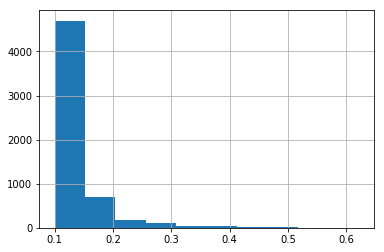

In [1271]:
%matplotlib inline
results.confidence.hist()

In [1272]:
# Limit Results based on object max frame confidence
max_conf = pd.DataFrame(results.groupby('objectid').confidence.max())
above_thresh = max_conf[max_conf.confidence > 0.30].index
results = results[[(obj in above_thresh) for obj in results.objectid]]

In [1273]:
len(results.objectid.value_counts())

44

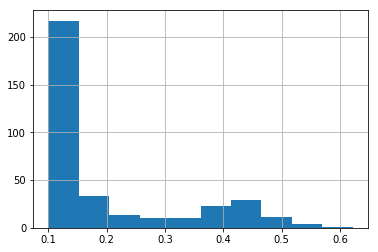

In [1274]:
%matplotlib inline
results.confidence.hist()

In [1275]:
# REVISED LABEL TRANSFER USING HIGHEST SUM OF CONFIDENCES

conf_sums = results.groupby(['objectid', 'label']).confidence.sum()
df = conf_sums.reset_index()
df2 = df.loc[df.groupby('objectid').label.idxmax()]
labels = dict(zip(df2.objectid, df2.label))
results['label'] = results.objectid.apply(lambda x: concepts[int(labels[x])])
results['conceptid'] = results['label']


In [1276]:
# REVISED LABEL TRANSFER USING HIGHEST MAXIMUM CONFIDENCE

# conf_max = results.groupby(['objectid', 'label']).confidence.max()
# df = conf_max.reset_index()
# df2 = df.loc[df.groupby('objectid').label.idxmax()]
# labels = dict(zip(df2.objectid, df2.label))
# results['label'] = results.objectid.apply(lambda x: concepts[int(labels[x])])
# results['conceptid'] = results['label']


In [1277]:
# Add the majority concept id to all frames

# label = None
# objects = results.groupby(['objectid'])
# for oid, result in objects:
#     scores = {}
#     # SHOULD THIS BE A WEIGHTED SUM??
#     for k , label in result.groupby(['label']):
#         scores[k] = label.confidence.mean() 
#     idmax = max(scores.keys(), key=(lambda k: scores[k]))
#     results.loc[results.objectid == oid,'label'] = idmax
# results['label'] = results['label'].apply(lambda x: concepts[int(x)])
# results['conceptid'] = results['label']

In [1278]:
#results.groupby('objectid').label.value_counts()

In [1279]:
# Limit results based on tracked object length ( > 30 frames)
obj_len = results.groupby('objectid').conceptid.value_counts()
len_thresh = obj_len[obj_len > 15]
results = results[[(obj in len_thresh) for obj in results.objectid]] 

In [1280]:
len(results.objectid.value_counts())

43

In [1281]:
# test counts

grouped = results.groupby(['objectid']).label.mean().reset_index()
counts = grouped.groupby('label').count()
counts.columns = ['pred_num']
groundtruth_counts = pd.DataFrame(annotations.groupby('conceptid').id.count())
groundtruth_counts.columns = ['true_num']
df = pd.concat((counts, groundtruth_counts), axis=1, join='outer').fillna(0)
df['count_error'] = (df.true_num - df.pred_num).abs() / df.true_num
concept_counts = df
concept_counts


,pred_num,true_num,count_error
236,8.0,143.0,0.944056
237,0.0,10.0,1.000000
383,34.0,148.0,0.770270
812,0.0,1.0,1.000000
1019,0.0,6.0,1.000000
1034,0.0,24.0,1.000000
1133,1.0,0.0,inf
1210,0.0,40.0,1.000000
1399,0.0,2.0,1.000000
3100,0.0,51.0,1.000000


In [1282]:
# Make fps an Integer
annotations['frame_num'] = np.rint(annotations['timeinvideo'] * fps)
annotations.head()

,id,videoid,userid,conceptid,timeinvideo,x1,y1,x2,y2,videowidth,videoheight,dateannotated,image,imagewithbox,comment,unsure,originalid,framenum,frame_num
0,4972131,86,15,383,7.399145,663.0,78.0,1008.0,271.0,1600.0,900.0,2019-02-28,1551325967699.png,1551325967699_box.png,,False,4972131,None,222.0
1,4972162,86,15,383,7.399145,164.0,35.0,542.0,246.0,1600.0,900.0,2019-02-28,1551325978189.png,1551325978189_box.png,,False,4972162,None,222.0
2,4972261,86,15,383,13.815457,281.0,162.0,659.0,373.0,1600.0,900.0,2019-02-28,1551326013658.png,1551326013658_box.png,,False,4972261,None,414.0
3,4972323,86,15,383,13.815457,126.0,5.0,422.0,192.0,1600.0,900.0,2019-02-28,1551326023375.png,1551326023375_box.png,,False,4972323,None,414.0
4,4972101,86,15,383,5.742937,592.0,354.0,1024.0,599.0,1600.0,900.0,2019-02-28,1551325952284.png,1551325952284_box.png,,False,4972101,None,172.0


In [1283]:
def resize(row):
    new_width = 640
    new_height = 480
    x_ratio = (row.videowidth / new_width)
    y_ratio = (row.videoheight / new_height)
    row.videowidth = new_width
    row.videoheight = new_height
    row.x1 = row.x1 / x_ratio
    row.x2 = row.x2 / x_ratio
    row.y1 = row.y1 / y_ratio
    row.y2 = row.y2 / y_ratio
    return row

In [1284]:
# RESIZE THE ANNOTATIONS
test_annotations = annotations.apply(resize, axis=1)

In [1285]:
# Important to convert frame number to int
test_annotations.frame_num = test_annotations.frame_num.astype(int)

In [1286]:
# pred_frames = results.frame_num.unique()
# test_frames = annotations.frame_num.unique()
# test_frames[[(val in pred_frames) for val in test_frames]]
# test_frames

In [1287]:
def score_predictions(validation, predictions, iou_thresh, concepts, fps):
    
    # Maintain a set of predicted objects to verify
    detected_objects = []
    obj_map = predictions.groupby('objectid', sort=False).conceptid.max()
    
    # group predictions by video frames
    predictions = predictions.groupby('frame_num', sort=False)
    predictions = [df for _, df in predictions]
    
    # mapping frames to predictions index
    frame_data = {}
    for i, group in enumerate(predictions):
        frame_num = group.iloc[0]['frame_num']
        frame_data[frame_num] = i
    
    # group validation annotations by frames
    validation = validation.groupby('frame_num', sort=False)
    validation = [df for _, df in validation]
    
    # initialize counters for each concept
    true_positives = dict(zip(concepts,[0] * len(concepts)))
    false_positives = dict(zip(concepts,[0] * len(concepts)))
    false_negatives = dict(zip(concepts,[0] * len(concepts)))
    
    # get true and false positives for each frame of validation data
    for group in validation:
        try: # get corresponding predictions for this frame
            frame_num = group.iloc[0]['frame_num']
            predicted = predictions[frame_data[frame_num]]
        except:
            continue # False Negatives already covered
            
        detected_truths = dict(zip(concepts, [0] * len(concepts)))
        for index, truth in group.iterrows():
            for index, prediction in predicted.iterrows():
                if (prediction.conceptid == truth.conceptid
                        and compute_overlap(truth, prediction) > iou_thresh
                        and prediction.objectid not in detected_objects):
                    detected_objects.append(prediction.objectid)
                    true_positives[prediction.conceptid] += 1
                    detected_truths[prediction.conceptid] += 1
                    
        # False Negatives (Missed ground truth predicitions)
        counts = group.conceptid.value_counts()
        for concept in concepts:
            count = counts[concept] if (concept in counts.index) else 0
            false_negatives[concept] += count - detected_truths[concept]
    
    # False Positives (No ground truth prediction at any frame for that object)
    undetected_objects = set(obj_map.index) - set(detected_objects)
    for obj in undetected_objects:
        concept = obj_map[obj]
        false_positives[concept] += 1
    
    metrics = pd.DataFrame()
    for concept in concepts:
        TP = true_positives[concept]
        FP = false_positives[concept]
        FN = false_negatives[concept]
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = (2*recall*precision / (precision+recall)) if (precision+recall) != 0 else 0
        metrics = metrics.append([[concept, TP, FP, FN, precision, recall, f1]])
    metrics.columns = ['conceptid', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1']
    return metrics


In [1288]:
fps = 29.97002997002997
metrics = score_predictions(test_annotations, results, 0.25, concepts, fps)


In [1289]:
#metrics.set_index('conceptid')

In [1290]:
metrics.set_index('conceptid').join(concept_counts)

,TP,FP,FN,Precision,Recall,F1,pred_num,true_num,count_error
conceptid,,,,,,,,,
1629,0,0,0,0.000000,0.000000,0.000000,NaN,NaN,NaN
1210,0,0,8,0.000000,0.000000,0.000000,0.0,40.0,1.000000
236,3,5,21,0.375000,0.125000,0.187500,8.0,143.0,0.944056
383,25,9,12,0.735294,0.675676,0.704225,34.0,148.0,0.770270
1133,0,1,0,0.000000,0.000000,0.000000,1.0,0.0,inf


In [ ]:
# Aim for 90% precision, at the sacrifice of 50% recall

In [ ]:
# make a threshold for the bounding box size of the annotation
# for the maximum confidence annotation in each object
# maybe 10x10 pixels

In [ ]:

# TRIED SUM OF CONFIDENCE AND PRECISION DECREASED???